**IMAGES AND LABELLING FOR TRAINING THE MODEL**

In [ ]:
import os
import pandas as pd
import shutil

base_dir = '/content/drive/MyDrive'
train_images_dir = os.path.join(base_dir, 'images/train')
train_labels_dir = os.path.join(base_dir, 'labels/train')
val_images_dir = os.path.join(base_dir, 'images/val')
val_labels_dir = os.path.join(base_dir, 'labels/val')

os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

csv_path = '/content/drive/MyDrive/Train.csv'
data = pd.read_csv(csv_path)

split_ratio = 0.8
train_size = int(len(data) * split_ratio)


data = data.sample(frac=1).reset_index(drop=True)
train_data = data[:train_size]
val_data = data[train_size:]

def copy_images_and_create_labels(data_subset, images_dir, labels_dir, image_base_path):
    for index, row in data_subset.iterrows():
        image_path = row['Path']
        class_id = row['ClassId']
        image_filename = os.path.basename(image_path)


        folder_name = os.path.dirname(image_path).split('/')[-1]

        # Check for images in the TRAIN directory
        full_image_path_train = os.path.join(image_base_path, 'Train', folder_name, image_filename)

        # Check for images in the validation directory
        full_image_path_val = os.path.join(image_base_path, 'validation', folder_name, image_filename)

        print(f"Checking: {full_image_path_train}")
        if os.path.exists(full_image_path_train):
            shutil.copy(full_image_path_train, images_dir)


            x_center = (row['Roi.X1'] + row['Roi.X2']) / 2 / row['Width']
            y_center = (row['Roi.Y1'] + row['Roi.Y2']) / 2 / row['Height']
            width = (row['Roi.X2'] - row['Roi.X1']) / row['Width']
            height = (row['Roi.Y2'] - row['Roi.Y1']) / row['Height']

            label_file_name = os.path.splitext(image_filename)[0] + '.txt'
            label_path = os.path.join(labels_dir, label_file_name)

            # Write to label file in YOLO format
            with open(label_path, 'a') as label_file:
                label_file.write(f"{int(class_id)} {x_center} {y_center} {width} {height}\n")
            print(f"Processed (TRAIN): {image_filename}")
        elif os.path.exists(full_image_path_val):
            shutil.copy(full_image_path_val, images_dir)

            # Prepare YOLO format for the label file
            x_center = (row['Roi.X1'] + row['Roi.X2']) / 2 / row['Width']
            y_center = (row['Roi.Y1'] + row['Roi.Y2']) / 2 / row['Height']
            width = (row['Roi.X2'] - row['Roi.X1']) / row['Width']
            height = (row['Roi.Y2'] - row['Roi.Y1']) / row['Height']

            label_file_name = os.path.splitext(image_filename)[0] + '.txt'
            label_path = os.path.join(labels_dir, label_file_name)

            # Write to label file in YOLO format
            with open(label_path, 'a') as label_file:
                label_file.write(f"{int(class_id)} {x_center} {y_center} {width} {height}\n")
            print(f"Processed (validation): {image_filename}")
        else:
            print(f"Image not found: {full_image_path_train} and {full_image_path_val}")

# Copy images and create label files for training and validation sets
copy_images_and_create_labels(train_data, train_images_dir, train_labels_dir, '/content/drive/MyDrive/TRAFFIC_SIGNS')
copy_images_and_create_labels(val_data, val_images_dir, val_labels_dir, '/content/drive/MyDrive/TRAFFIC_SIGNS')



Streaming output truncated to the last 5000 lines.
Checking: /content/drive/MyDrive/TRAFFIC_SIGNS/Train/12/00012_00047_00012.png
Image not found: /content/drive/MyDrive/TRAFFIC_SIGNS/Train/12/00012_00047_00012.png and /content/drive/MyDrive/TRAFFIC_SIGNS/validation/12/00012_00047_00012.png
Checking: /content/drive/MyDrive/TRAFFIC_SIGNS/Train/4/00004_00043_00003.png
Image not found: /content/drive/MyDrive/TRAFFIC_SIGNS/Train/4/00004_00043_00003.png and /content/drive/MyDrive/TRAFFIC_SIGNS/validation/4/00004_00043_00003.png
Checking: /content/drive/MyDrive/TRAFFIC_SIGNS/Train/1/00001_00016_00016.png
Image not found: /content/drive/MyDrive/TRAFFIC_SIGNS/Train/1/00001_00016_00016.png and /content/drive/MyDrive/TRAFFIC_SIGNS/validation/1/00001_00016_00016.png
Checking: /content/drive/MyDrive/TRAFFIC_SIGNS/Train/33/00033_00013_00009.png
Image not found: /content/drive/MyDrive/TRAFFIC_SIGNS/Train/33/00033_00013_00009.png and /content/drive/MyDrive/TRAFFIC_SIGNS/validation/33/00033_00013_00009

**CHANGING THE LABELS TO COMPRESS THEM FROM 39 CLASSES TO 22 CLASSES for taking only the important detections:**

In [ ]:
import os

class_mapping = {
    19: 16,  # Dangerous curve left
    20: 17,  # Dangerous curve right
    27: 18,  # Pedestrians
    33: 19,  # Turn right ahead
    34: 20,  # Turn left ahead
    38: 21,  # Keep right
    39: 22   # Keep left
}

annotations_dir = '/content/drive/MyDrive/labels/val'

# Function to update annotations
def update_annotations(directory):
    global count
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):  # Assuming annotations are in .txt format
            file_path = os.path.join(directory, filename)
            updated_lines = []
            with open(file_path, 'r') as file:
                for line in file:
                    parts = line.strip().split()  # Split the line into components
                    if len(parts) > 0:
                        original_class_id = int(parts[0])
                        new_class_id = class_mapping.get(original_class_id, original_class_id)
                        # Create the updated line with the new class ID
                        updated_line = f"{new_class_id} {' '.join(parts[1:])}"
                        updated_lines.append(updated_line)

            with open(file_path, 'w') as file:
                for updated_line in updated_lines:
                    file.write(updated_line + '\n')
                    count += 1

count = 0
update_annotations(annotations_dir)

print("Annotation files updated successfully.")
print(count)

Annotation files updated successfully.
125


**Importing YOLOv5 Model for Training from Scratch (Without Pre-trained Weights)**




In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17045, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17045 (delta 10), reused 18 (delta 8), pack-reused 17022 (from 1)
Receiving objects: 100% (17045/17045), 15.67 MiB | 18.34 MiB/s, done.
Resolving deltas: 100% (11704/11704), done.
/content/yolov5/yolov5
  Using cached thop-0.1.1.post2209072238-py3-none-any.whl.metadata (2.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.8/883.8 kB 24.6 MB/s eta 0:00:00


**Creating a Custom YAML File for YOLOv5 Training**

In [ ]:
yaml_file_path = '/content/yolov5/data/custom_data.yaml'

yaml_content = """
train: /content/drive/MyDrive/images/train  # path to training images
val: /content/drive/MyDrive/images/val      # path to validation images

nc: 23  # number of classes
names: [
    '20', '30', '50', '60',
    '70', '80', '90', '150',
    '120', 'NO OVERTAKING', 'NO OVERTAKING TRUCK', 'Right-of-way at intersection',
    'INTERSECTION', 'YEILD SIGN', 'STOP', 'NOT ALLOWED',
    'Dangerous curve left', 'Dangerous curve right', 'Pedestrians',
    'Turn right ahead', 'Turn left ahead', 'Keep right', 'Keep left'
]
"""

with open(yaml_file_path, 'w') as f:
    f.write(yaml_content.strip())

print(f"YAML file created at {yaml_file_path}.")


YAML file created at /content/yolov5/data/custom_data.yaml.


**TRAINING THE MODEL**

In [ ]:
!python /content/yolov5/train.py --img 640 --batch 16 --epochs 60 --data /content/yolov5/data/custom_data.yaml


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-03 14:16:01.091341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-03 14:16:01.112098: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-03 14:16:01.122652: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visual

**Displaying YOLOv5 Training Metrics as Graphs**

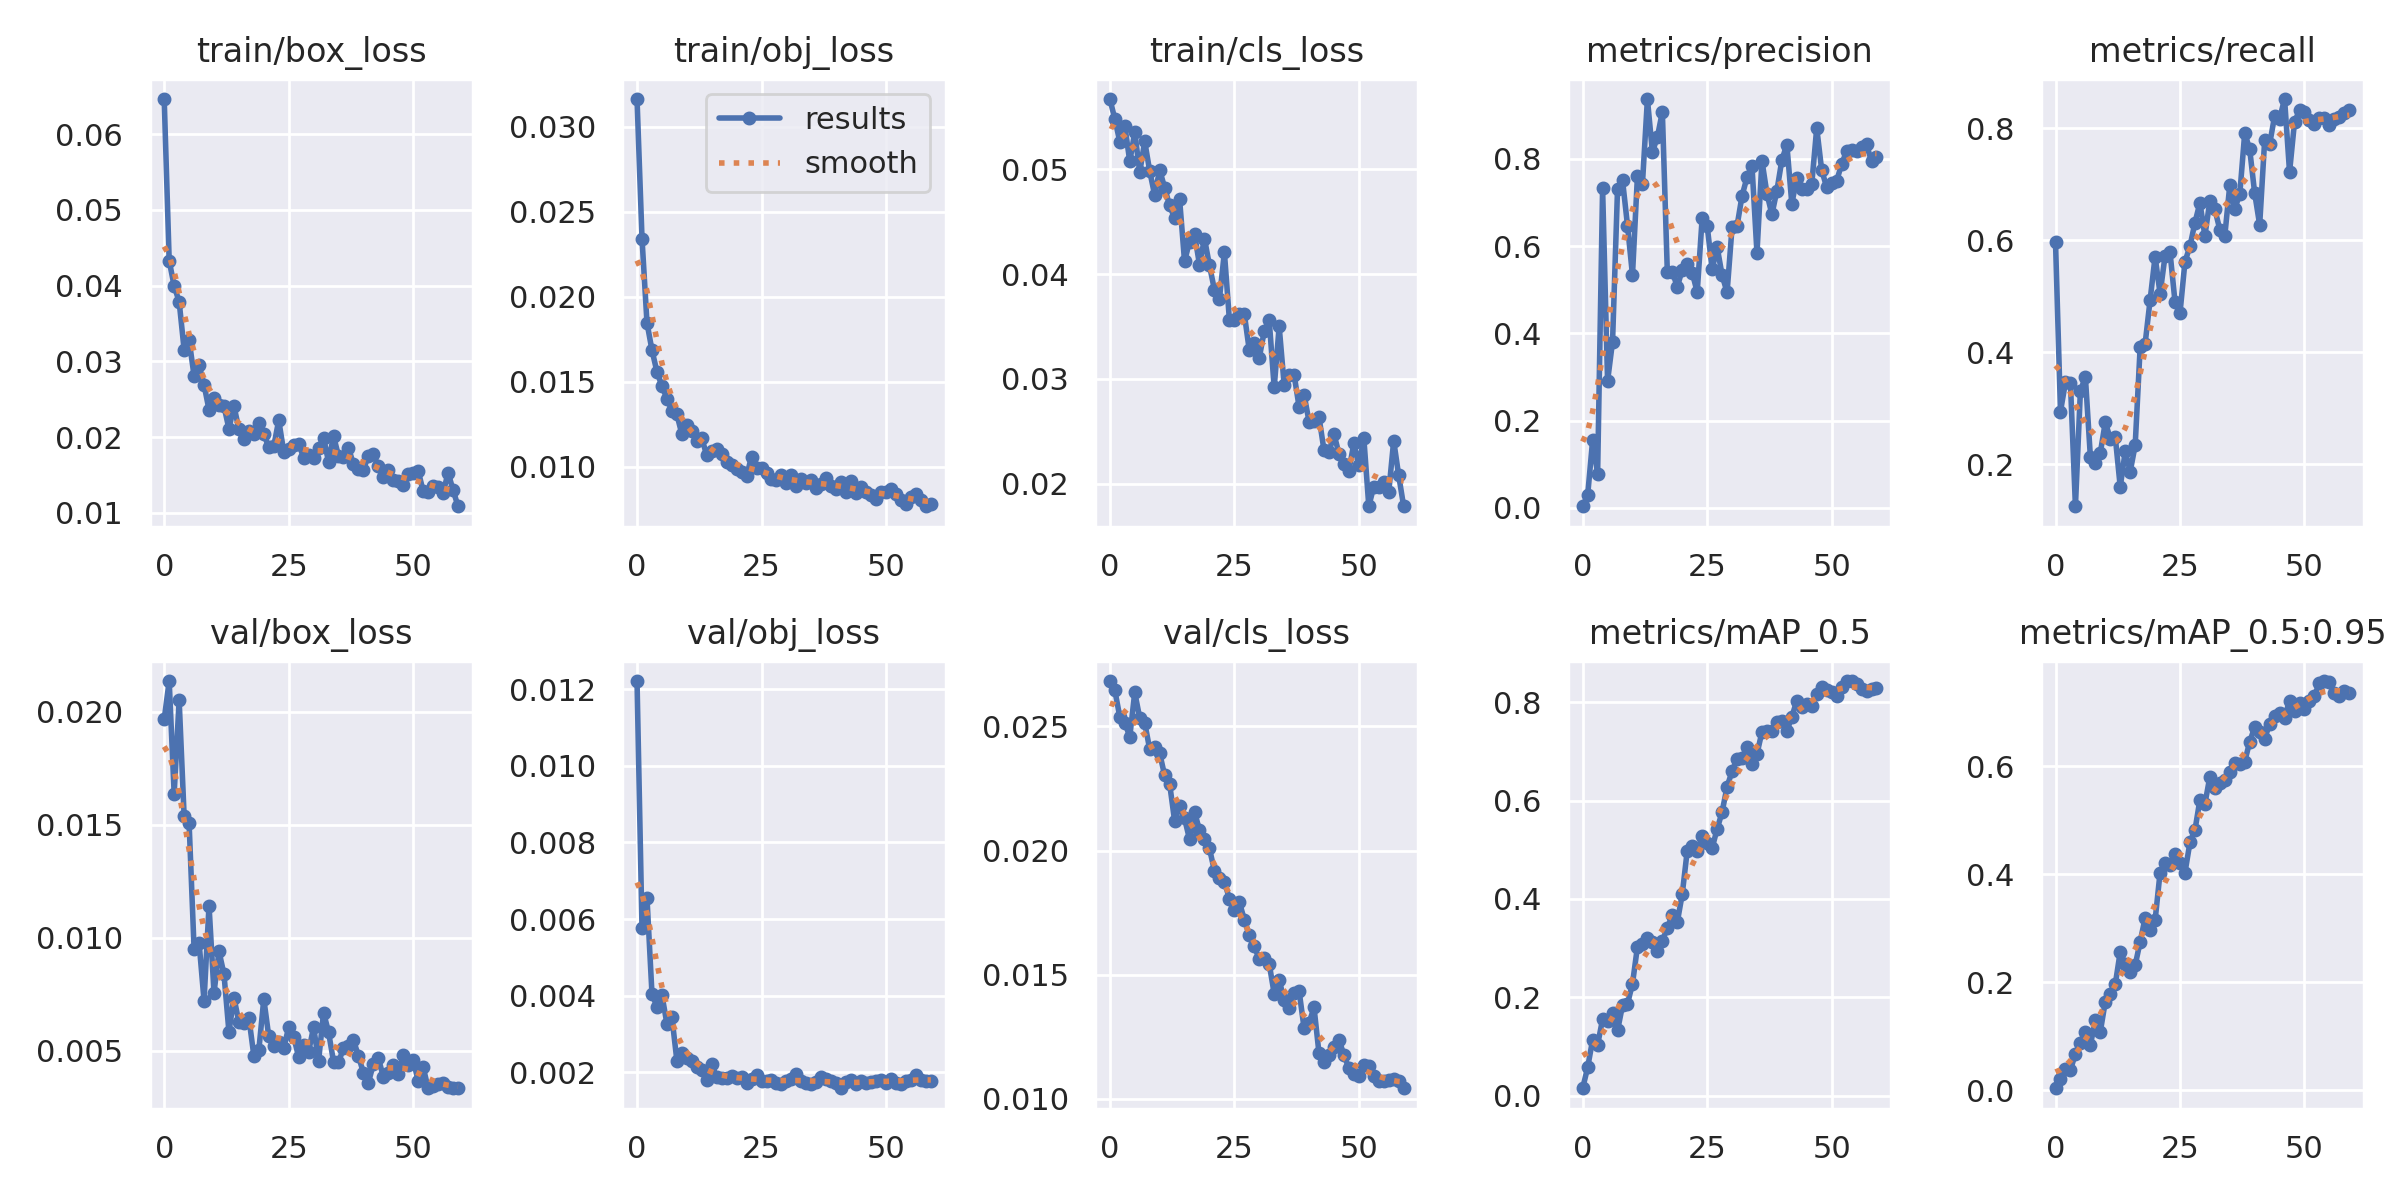

In [ ]:
from IPython.display import Image, display
import glob

latest_results = sorted(glob.glob('/content/yolov5/runs/train/exp2/results.png'), key=len)[-1]
display(Image(filename=latest_results, width=800))

**DOWNLOADED THE MODEL FOR FURTHER PROCESSING**



**LIBRARIES REQUIRD FOR TESTING**

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from google.colab.patches import cv2_imshow

**LOADING THE TRAINED YOLOV5 MODEL**

In [ ]:
import torch
model = torch.hub.load('ultralytics/yolov5', 'custom', path= '/content/drive/MyDrive/INFOSYS_FILES/best.pt', force_reload=True)


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 v7.0-383-g1435a8ee Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7053277 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


**TESTING WITH IMAGES**

Raw predictions: [[     23.472      47.369      604.11      578.66     0.51396           3]]
Raw predictions: [[     23.817      46.278      619.29         418     0.38494          12]]
Raw predictions: [[     66.697      24.899       579.1      608.95     0.33216          11]]


/content/yolov5/yolov5/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/content/yolov5/yolov5/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/content/yolov5/yolov5/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


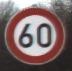

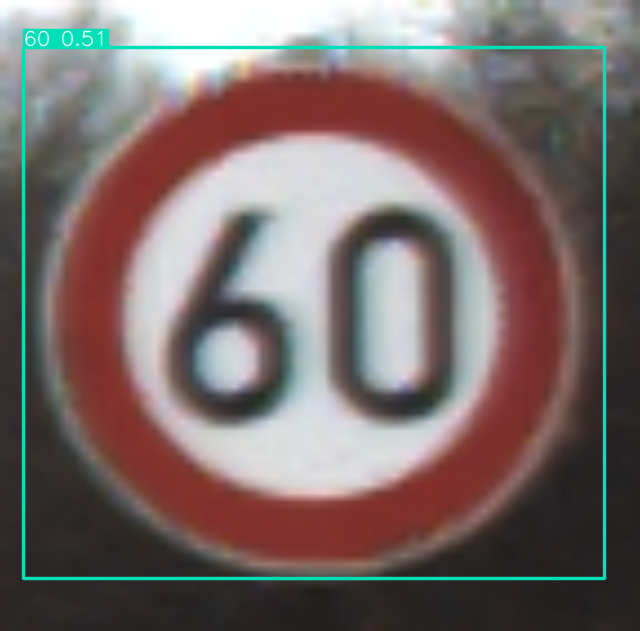

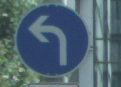

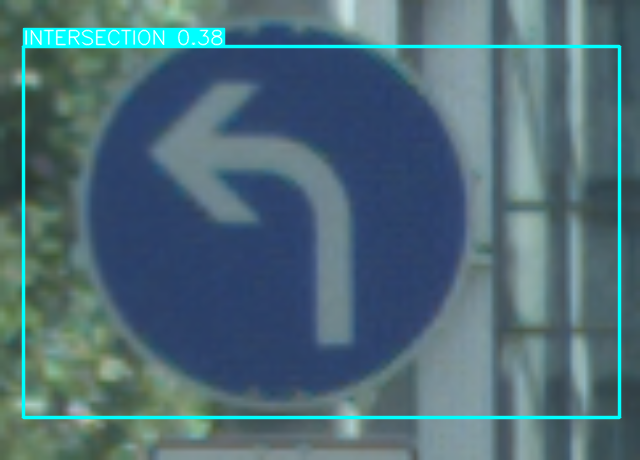

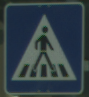

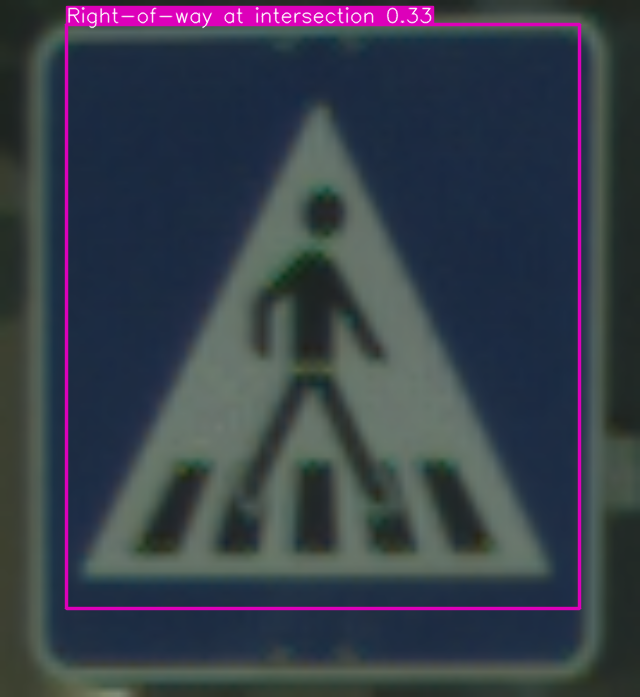

In [ ]:
# Specify the image paths
image_files = ['/content/TEST_IMG1.png', '/content/TEST_IMG2.png' , '/content/TEST_IMG3.png']

# Create a directory to save results
results_dir = '/content/yolov5/results'
os.makedirs(results_dir, exist_ok=True)

def resize_image(image, target_width):
    height, width = image.shape[:2]
    scale = target_width / width
    new_size = (target_width, int(height * scale))
    return cv2.resize(image, new_size)

# Iterate through each image, perform inference, and save results
results_data = []
for image_path in image_files:
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = resize_image(img_rgb, 640)

    results = model(img_resized)

    # results.print()

    # Raw predictions output for debugging
    raw_preds = results.pred[0].cpu().numpy()
    print("Raw predictions:", raw_preds)

    result_img = results.render()[0]

    # Collect results for plotting
    results_data.append((img_rgb, result_img, raw_preds))

    # Save the result image
    output_image_path = os.path.join(results_dir, f"{Path(image_path).stem}_result.png")
    cv2.imwrite(output_image_path, cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR))  # Save the result in BGR format


# Display saved results using OpenCV
for original_img, result_img, preds in results_data:
    original_img_bgr = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
    cv2_imshow(original_img_bgr)
    cv2.waitKey(0)

    result_img_bgr = cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR)
    cv2_imshow(result_img_bgr)
    cv2.waitKey(0)


plt.tight_layout()
